In [2]:
# USAGE
# python pi_object_detection.py --prototxt MobileNetSSD_deploy.prototxt.txt --model MobileNetSSD_deploy.caffemodel

# import the necessary packages
from imutils.video import VideoStream
from imutils.video import FPS
from multiprocessing import Process
from multiprocessing import Queue
import numpy as np
import argparse
import imutils
import time
import cv2
import io
from IPython.display import clear_output, Image, display
import PIL.Image
from IPython.display import clear_output
import json
import requests
import os
import datetime
import pytz





pushover=json.loads(open('/playground/Smart-Motion-Detector/keys.json').read())




def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
    
def classify_frame(net, inputQueue, outputQueue):
    # keep looping
    while True:
        # check to see if there is a frame in our input queue
        if not inputQueue.empty():
            # grab the frame from the input queue, resize it, and
            # construct a blob from it
            frame = inputQueue.get()
            frame = cv2.resize(frame, (300, 300))
            blob = cv2.dnn.blobFromImage(frame, 0.007843,
                (300, 300), 127.5)

            # set the blob as input to our deep learning object
            # detector and obtain the detections
            net.setInput(blob)
            detections = net.forward()

            # write the detections to the output queue
            outputQueue.put(detections)

"""
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--prototxt", required=True,
    help="path to Caffe 'deploy' prototxt file")
ap.add_argument("-m", "--model", required=True,
    help="path to Caffe pre-trained model")
ap.add_argument("-c", "--confidence", type=float, default=0.2,
    help="minimum probability to filter weak detections")
args = vars(ap.parse_args())
"""
args = {
    'model': 'MobileNetSSD_deploy.caffemodel',
    'prototxt': 'MobileNetSSD_deploy.prototxt.txt',
    'confidence': 0.6
}

# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
    "sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))




# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

# initialize the input queue (frames), output queue (detections),
# and the list of actual detections returned by the child process
inputQueue = Queue(maxsize=1)
outputQueue = Queue(maxsize=1)
detections = None

# construct a child process *indepedent* from our main process of
# execution
print("[INFO] starting process...")
p = Process(target=classify_frame, args=(net, inputQueue,
    outputQueue,))
p.daemon = True
p.start()

# initialize the video stream, allow the cammera sensor to warmup,
# and initialize the FPS counter
print("[INFO] starting video stream...")
vs = cv2.VideoCapture('rtsp://192.168.1.240:554/s2')  #VideoStream(src=0).start()
# vs = VideoStream(usePiCamera=True).start()
time.sleep(2.0)
fps = FPS().start()



prev_img = [1]

# loop over the frames from the video stream
while True:
    
    now = datetime.datetime.now().astimezone(pytz.timezone("Europe/Berlin"))
    # grab the frame from the threaded video stream, resize it, and
    # grab its dimensions
    ret, img = vs.read()
    frame = img
    confidence = 0
    classes = []
    if ret:
        #print(now)
        #print('ret: ', ret)
        #print((prev_img != frame).all())
        #if (prev_img != frame).all():
        frame = imutils.resize(frame, width=400)
        (fH, fW) = frame.shape[:2]

        # if the input queue *is* empty, give the current frame to
        # classify
        if inputQueue.empty():
            #print('Queue empty.')
            inputQueue.put(frame)

        # if the output queue *is not* empty, grab the detections
        if not outputQueue.empty():
            #print('Queue not empty. Grabbing detections.')
            detections = outputQueue.get()

        # check to see if our detectios are not None (and if so, we'll
        # draw the detections on the frame)
        if detections is not None:

            # loop over the detections
            for i in np.arange(0, detections.shape[2]):
                # extract the confidence (i.e., probability) associated
                # with the prediction
                confidence = detections[0, 0, i, 2]
                # filter out weak detections by ensuring the `confidence`
                # is greater than the minimum confidence

                # extract the index of the class label from the `detections`
                idx = int(detections[0, 0, i, 1])
                label = "{}: {:.2f}%".format(CLASSES[idx],
                    confidence * 100)

                #if confidence == 0:
                    #continue
                    #print('found detections.')
                    #print('label: ', label)
        
                if idx != 15:
                    continue

                #if confidence < args["confidence"]:
                #    continue

                classes.append(CLASSES[idx])

                # compute the (x, y)-coordinates
                # of the bounding box for the object
                #idx = int(detections[0, 0, i, 1])
                dims = np.array([fW, fH, fW, fH])
                box = detections[0, 0, i, 3:7] * dims
                (startX, startY, endX, endY) = box.astype("int")

                # draw the prediction on the frame
                #label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
                cv2.rectangle(frame, (startX, startY), (endX, endY),
                    COLORS[idx], 2)
                y = startY - 15 if startY - 15 > 15 else startY + 15
                cv2.putText(frame, label, (startX, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
            
            #print(classes)
            if 'person' in classes:
                print('person detected.')
                print('Sending push notification.')
                showarray(frame)
                boxed_img_path = '/playground/motioneye/detections/boxed.jpg'
                cv2.imwrite(boxed_img_path, frame)

                # Send Notification
                pushover['message'] = ', '.join(list(set(classes))) + ' detected!'

                r = requests.post("https://api.pushover.net/1/messages.json", data = pushover,
                files = {
                  "attachment": (os.path.basename(boxed_img_path), open(boxed_img_path, "rb"), "image/jpeg")
                })

                print(r.text)

        # show the output frame
        #cv2.imshow("Frame", frame)
        #showarray(frame)
        #clear_output()
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # update the FPS counter
    prev_img = img
    time.sleep(1)
    fps.update()
        

# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] loading model...


KeyboardInterrupt: 

In [ ]:
vs = cv2.VideoCapture('/playground/Smart-Motion-Detector/2019-01-08T15-00-00.mp4')



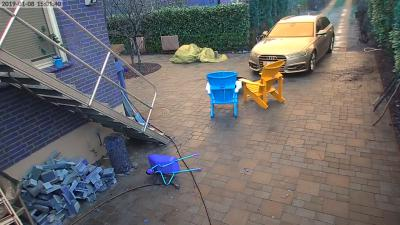

car: 38.61%
chair: 35.14%


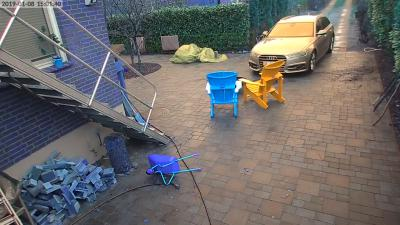

car: 38.61%
chair: 35.14%


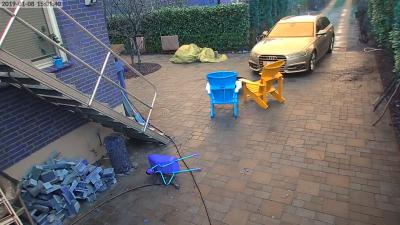

car: 38.61%
chair: 35.14%


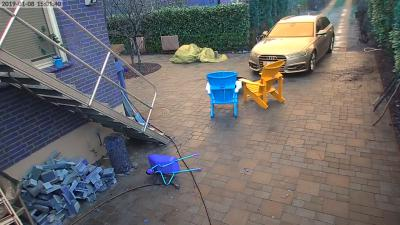

car: 38.61%
chair: 35.14%


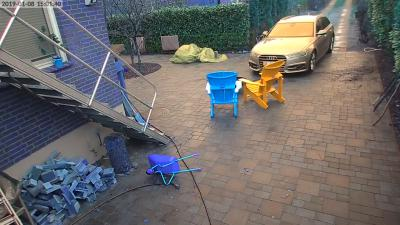

car: 38.61%
chair: 35.14%


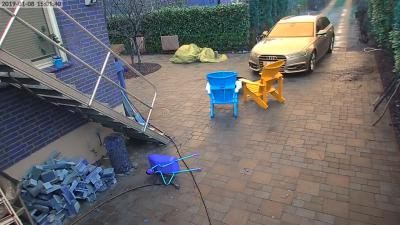

car: 38.61%
chair: 35.14%


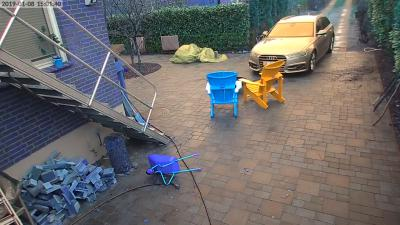

car: 38.61%
chair: 35.14%


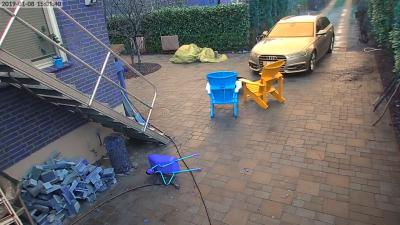

car: 38.61%
chair: 35.14%


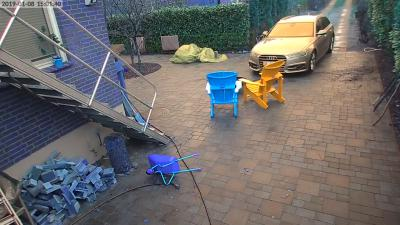

car: 38.61%
chair: 35.14%


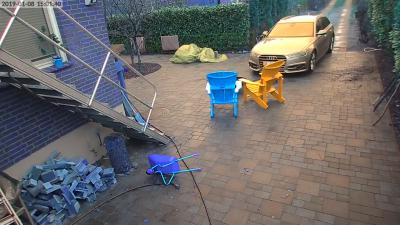

car: 38.61%
chair: 35.14%


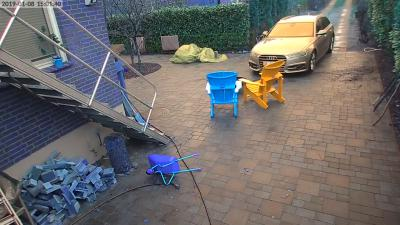

car: 38.61%
chair: 35.14%


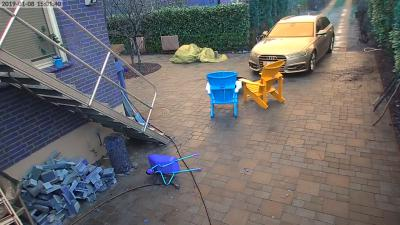

car: 38.61%
chair: 35.14%


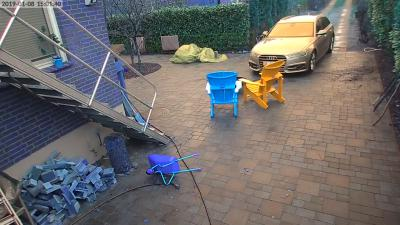

car: 38.61%
chair: 35.14%


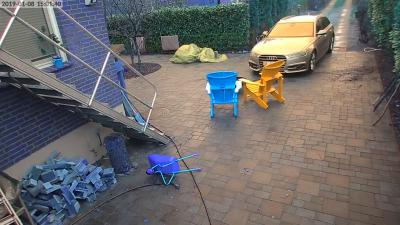

car: 38.61%
chair: 35.14%


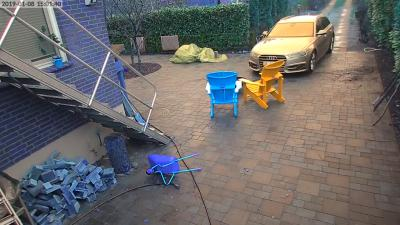

car: 38.61%
chair: 35.14%


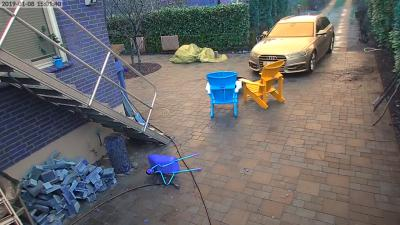

car: 38.61%
chair: 35.14%


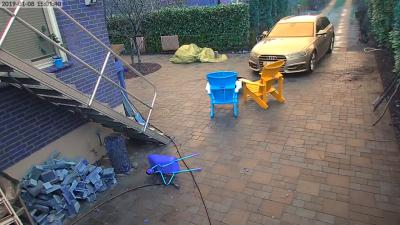

car: 38.61%
chair: 35.14%


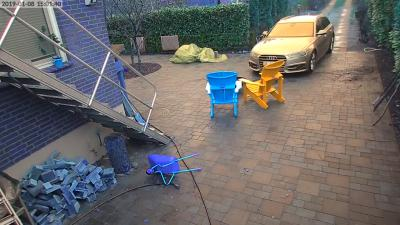

car: 38.61%
chair: 35.14%


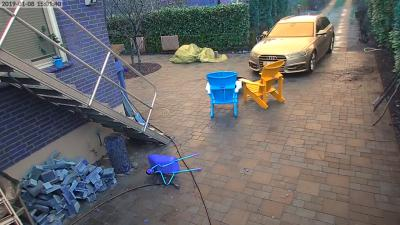

car: 38.61%
chair: 35.14%


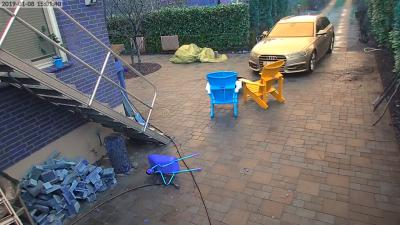

car: 38.61%
chair: 35.14%


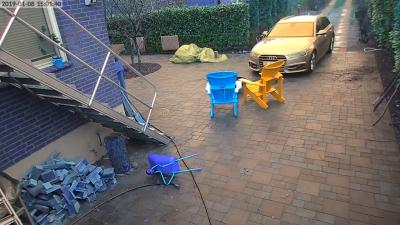

car: 38.61%
chair: 35.14%


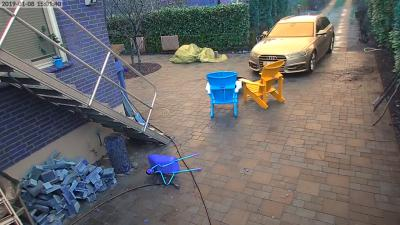

car: 38.61%
chair: 35.14%


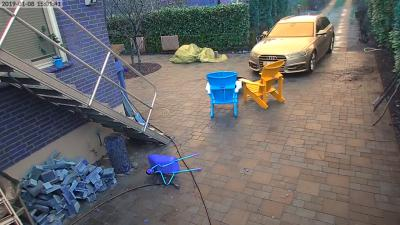

car: 38.61%
chair: 35.14%


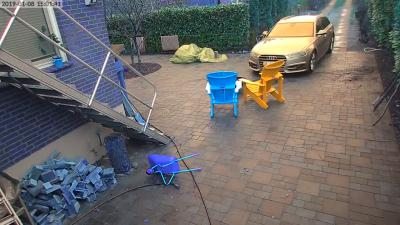

car: 38.61%
chair: 35.14%


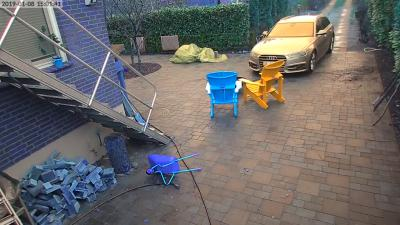

car: 38.61%
chair: 35.14%


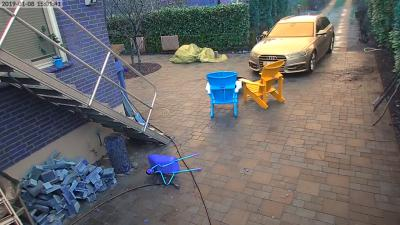

car: 38.61%
chair: 35.14%


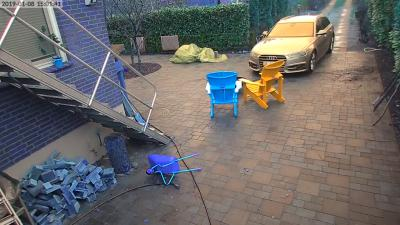

car: 38.61%
chair: 35.14%


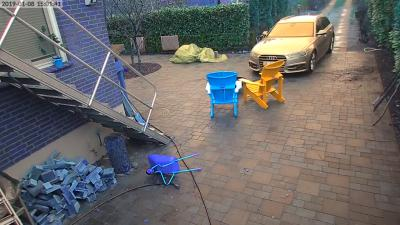

car: 38.61%
chair: 35.14%


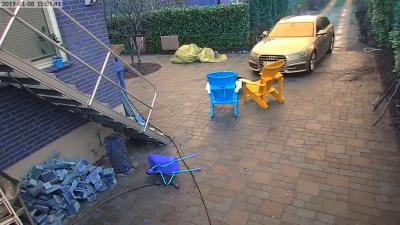

car: 38.61%
chair: 35.14%


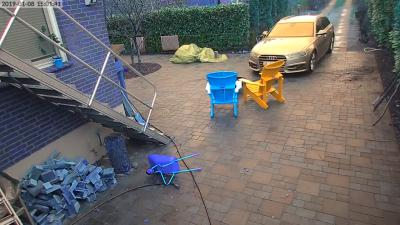

car: 38.61%
chair: 35.14%


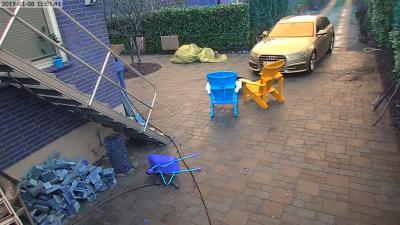

car: 38.61%
chair: 35.14%


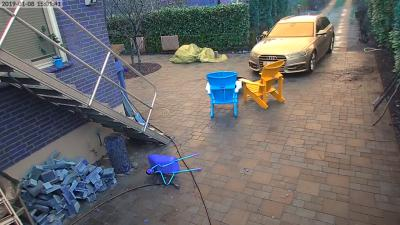

car: 38.61%
chair: 35.14%


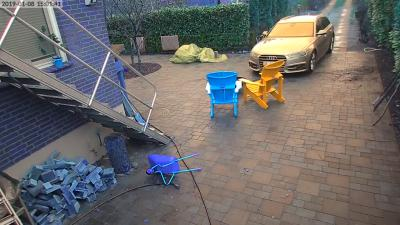

car: 38.61%
chair: 35.14%


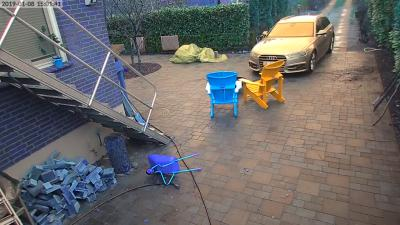

car: 38.61%
chair: 35.14%


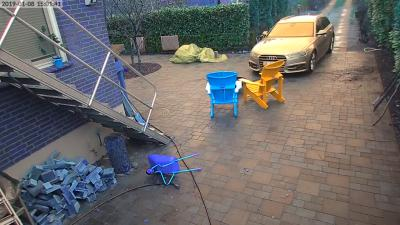

car: 38.61%
chair: 35.14%


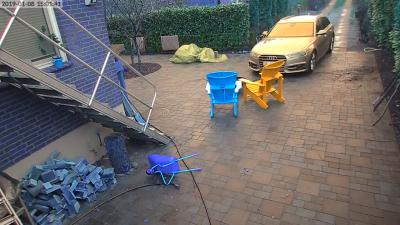

car: 38.61%
chair: 35.14%


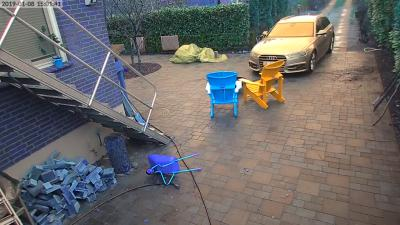

car: 38.61%
chair: 35.14%


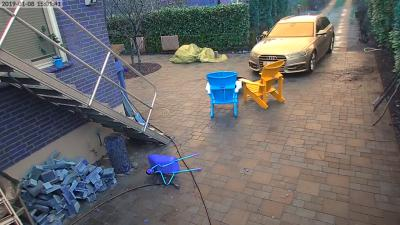

car: 38.61%
chair: 35.14%


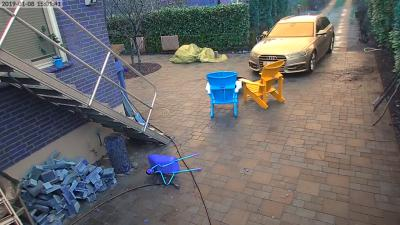

car: 38.61%
chair: 35.14%


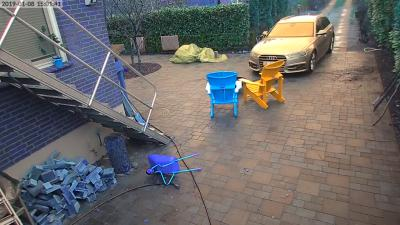

car: 38.61%
chair: 35.14%


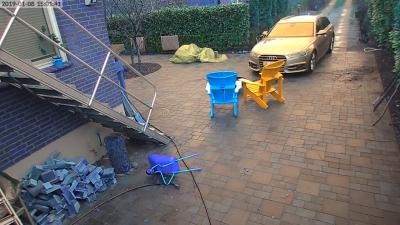

car: 38.61%
chair: 35.14%


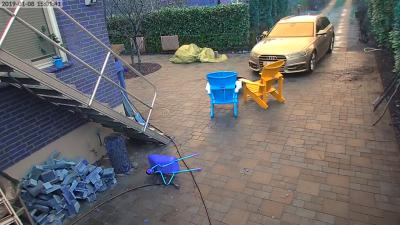

car: 38.61%
chair: 35.14%


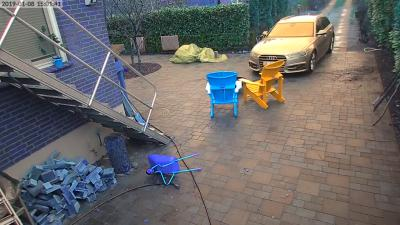

car: 38.61%
chair: 35.14%


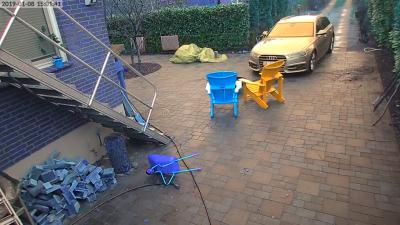

car: 38.61%
chair: 35.14%


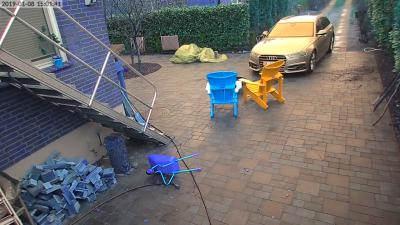

car: 38.61%
chair: 35.14%


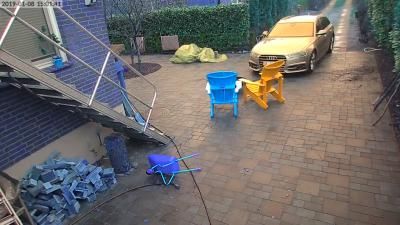

car: 38.61%
chair: 35.14%


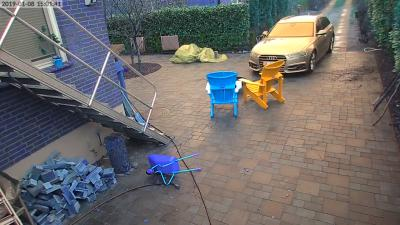

car: 38.61%
chair: 35.14%


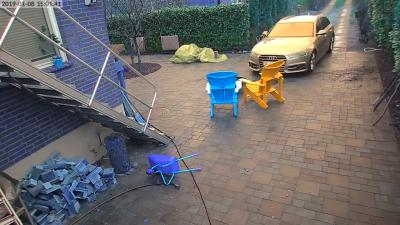

car: 38.61%
chair: 35.14%


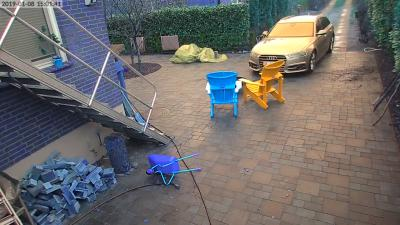

car: 38.61%
chair: 35.14%


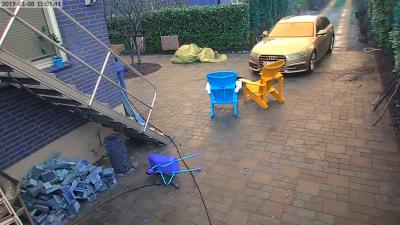

car: 38.61%
chair: 35.14%


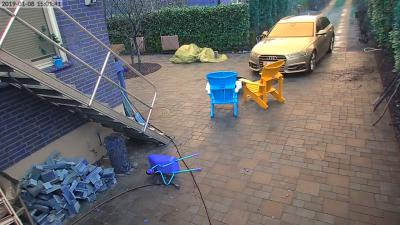

car: 38.61%
chair: 35.14%


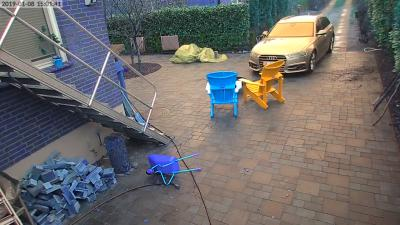

car: 38.61%
chair: 35.14%


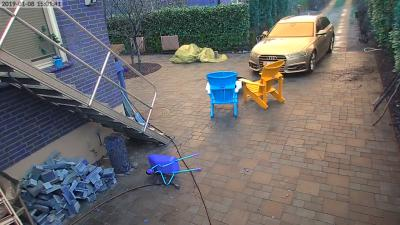

car: 38.61%
chair: 35.14%


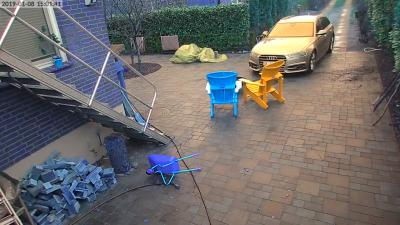

car: 38.61%
chair: 35.14%


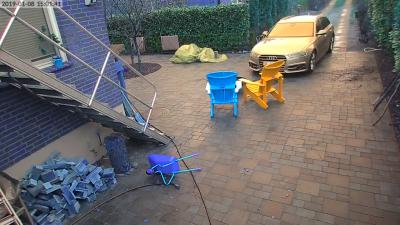

car: 38.61%
chair: 35.14%


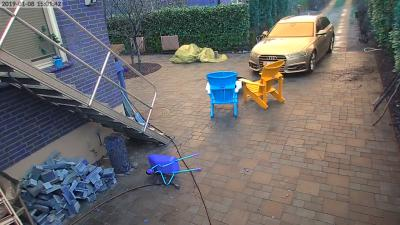

car: 38.61%
chair: 35.14%


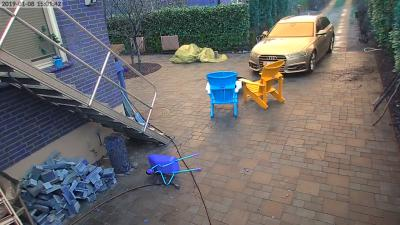

car: 38.61%
chair: 35.14%


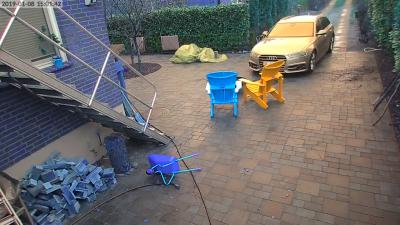

car: 38.61%
chair: 35.14%


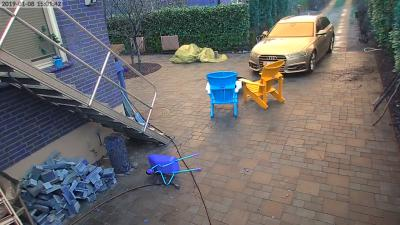

car: 38.61%
chair: 35.14%


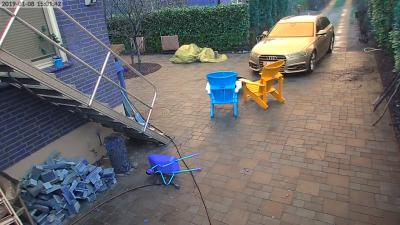

car: 38.61%
chair: 35.14%


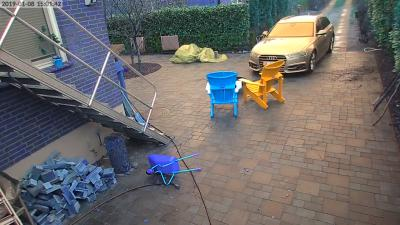

car: 38.61%
chair: 35.14%


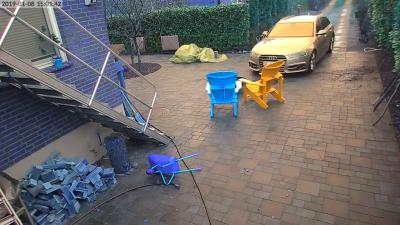

car: 38.61%
chair: 35.14%


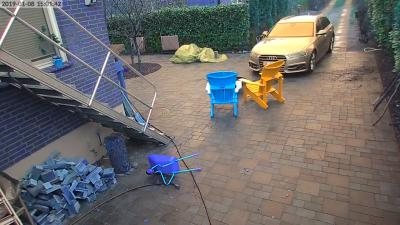

car: 38.61%
chair: 35.14%


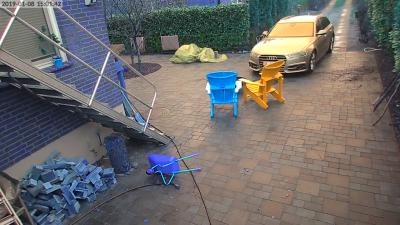

car: 38.61%
chair: 35.14%


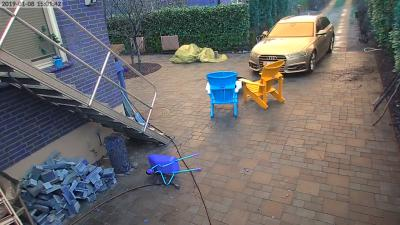

car: 38.61%
chair: 35.14%


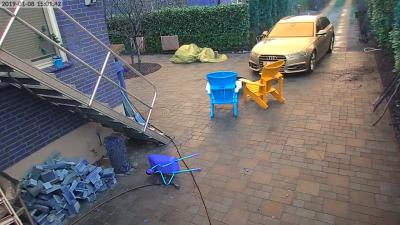

car: 38.61%
chair: 35.14%


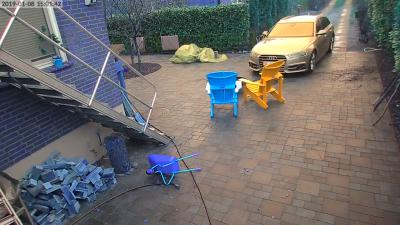

car: 38.61%
chair: 35.14%


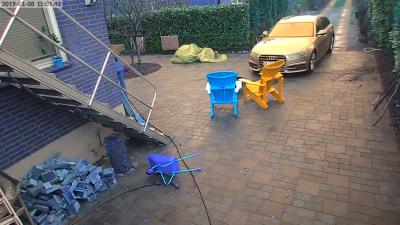

car: 38.61%
chair: 35.14%


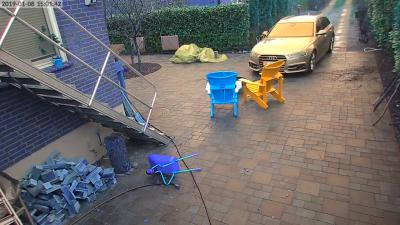

car: 38.61%
chair: 35.14%


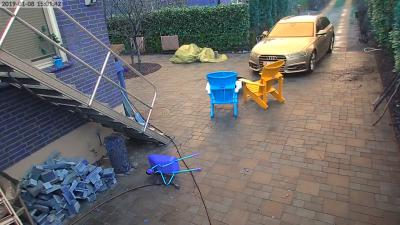

car: 38.61%
chair: 35.14%


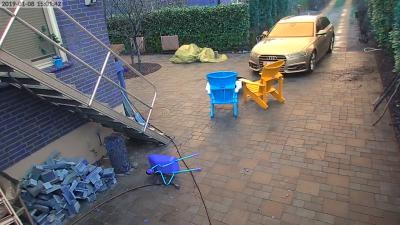

car: 38.61%
chair: 35.14%


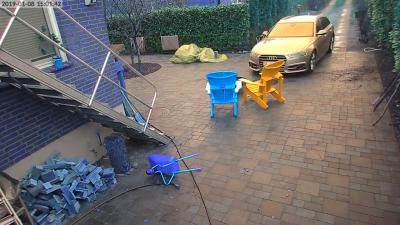

car: 38.61%
chair: 35.14%


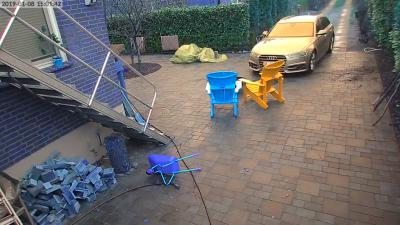

car: 38.61%
chair: 35.14%


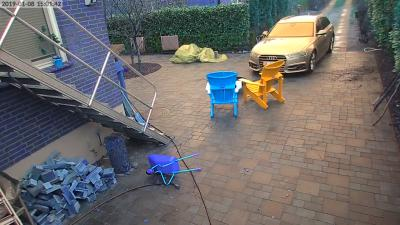

car: 38.61%
chair: 35.14%


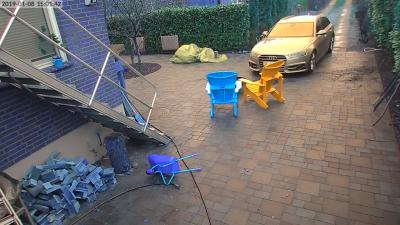

car: 38.61%
chair: 35.14%


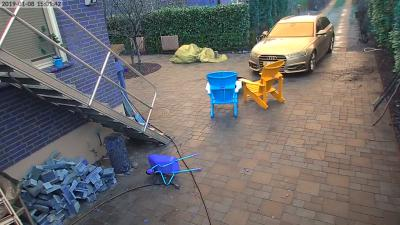

car: 38.61%
chair: 35.14%


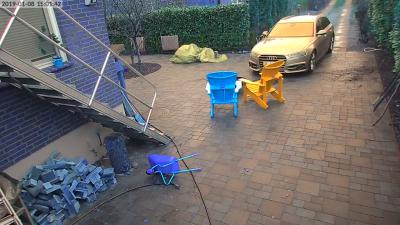

car: 38.61%
chair: 35.14%


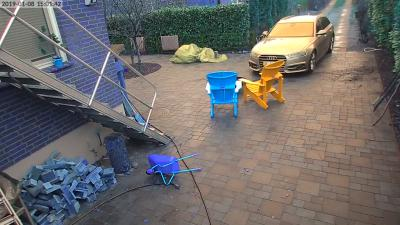

car: 38.61%
chair: 35.14%


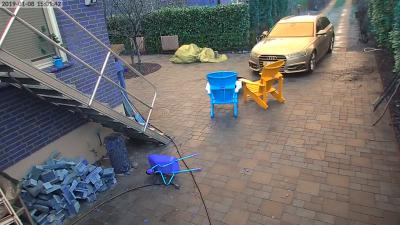

car: 38.61%
chair: 35.14%


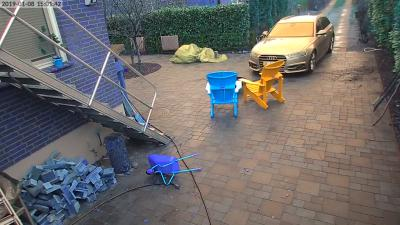

car: 38.61%
chair: 35.14%


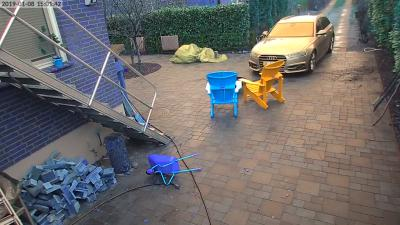

car: 38.61%
chair: 35.14%


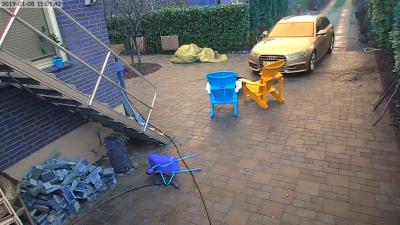

car: 38.61%
chair: 35.14%


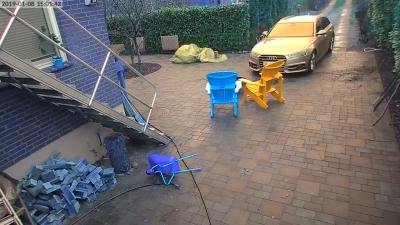

car: 38.61%
chair: 35.14%


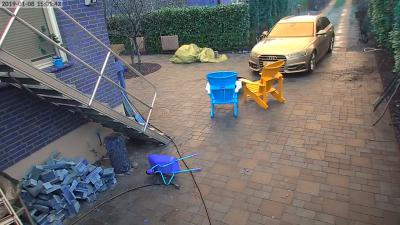

car: 38.61%
chair: 35.14%


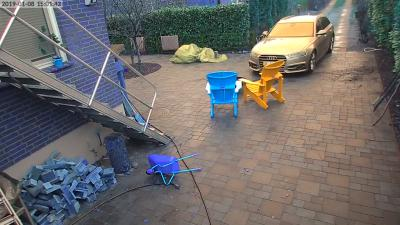

car: 38.61%
chair: 35.14%


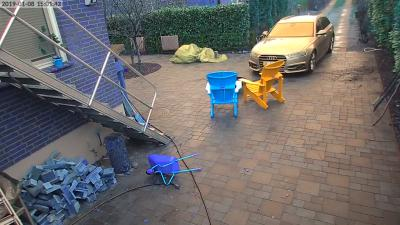

car: 38.61%
chair: 35.14%


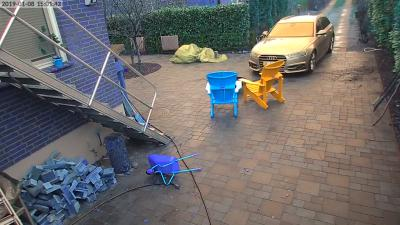

car: 38.61%
chair: 35.14%


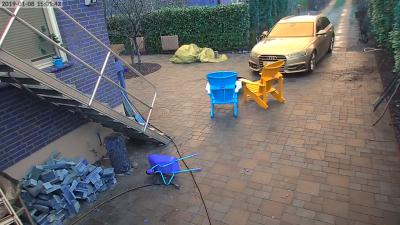

car: 38.61%
chair: 35.14%


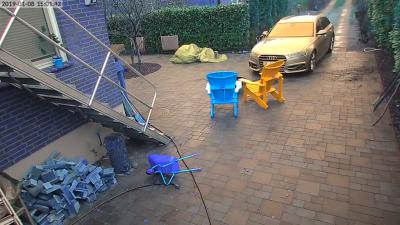

car: 38.61%
chair: 35.14%


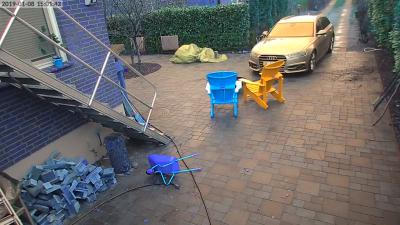

car: 38.61%
chair: 35.14%


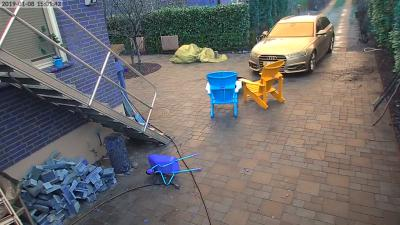

car: 38.61%
chair: 35.14%


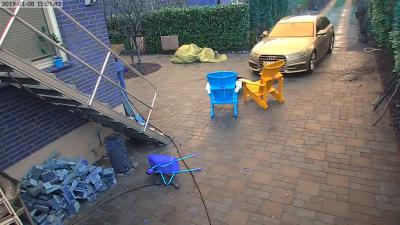

car: 38.61%
chair: 35.14%


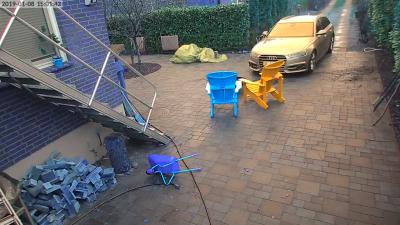

car: 38.61%
chair: 35.14%


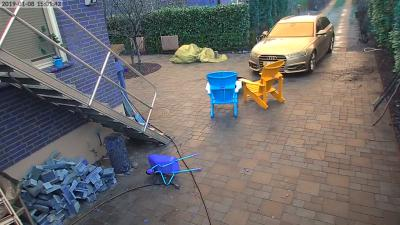

car: 38.61%
chair: 35.14%


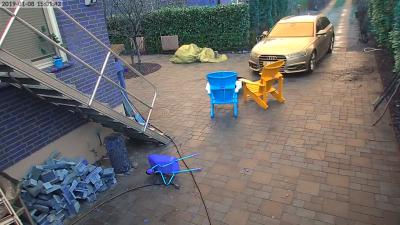

car: 38.61%
chair: 35.14%


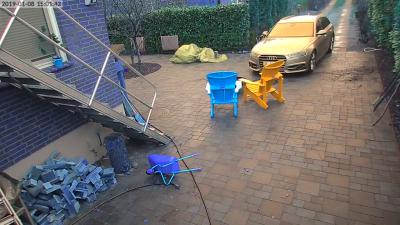

car: 38.61%
chair: 35.14%


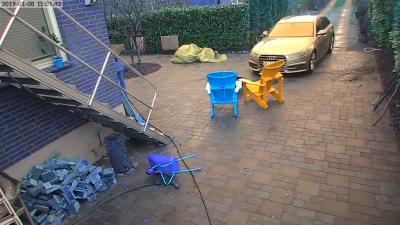

car: 38.61%
chair: 35.14%


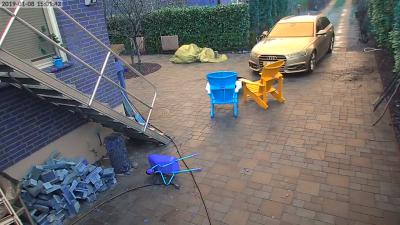

car: 38.61%
chair: 35.14%


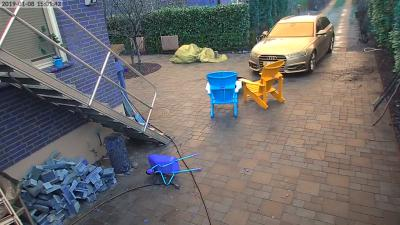

car: 38.61%
chair: 35.14%


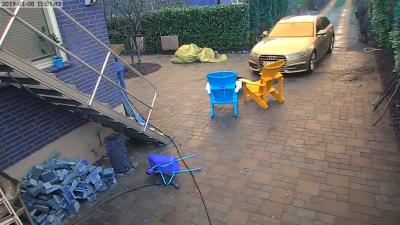

car: 38.61%
chair: 35.14%


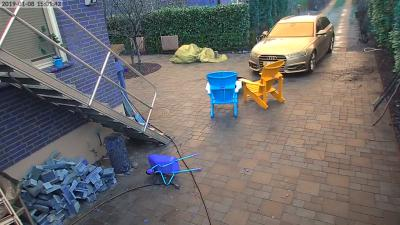

car: 38.61%
chair: 35.14%


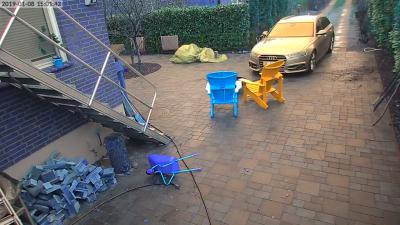

car: 38.61%
chair: 35.14%


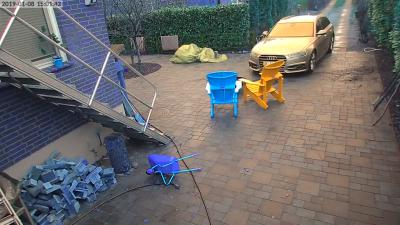

car: 38.61%
chair: 35.14%


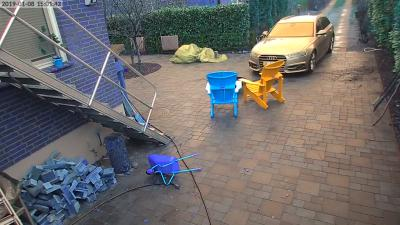

car: 38.61%
chair: 35.14%


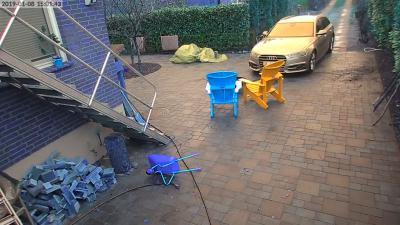

car: 38.61%
chair: 35.14%


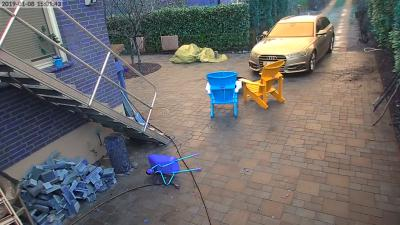

car: 38.61%
chair: 35.14%


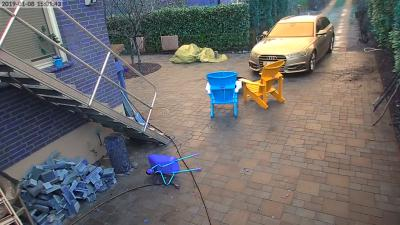

car: 38.61%
chair: 35.14%


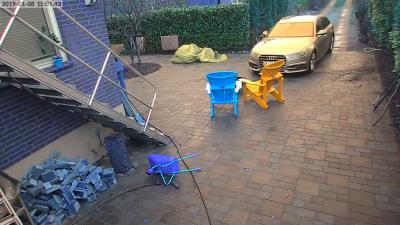

car: 38.61%
chair: 35.14%


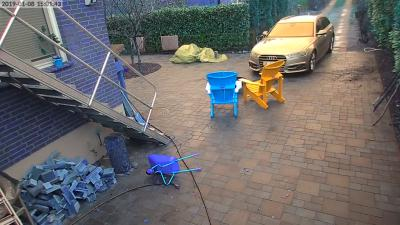

car: 38.61%
chair: 35.14%


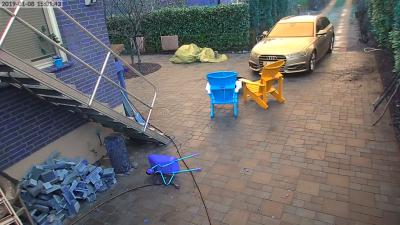

car: 38.61%
chair: 35.14%


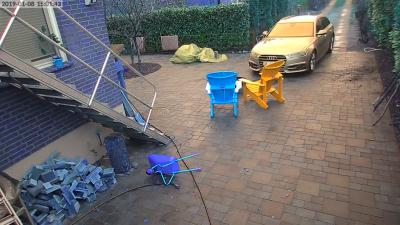

car: 38.61%
chair: 35.14%


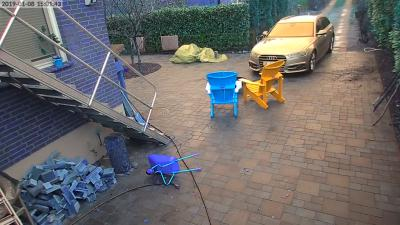

car: 38.61%
chair: 35.14%


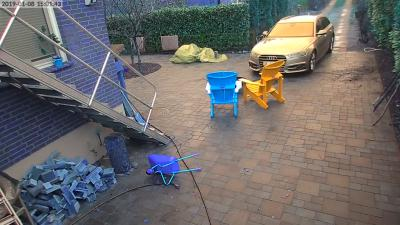

car: 38.61%
chair: 35.14%


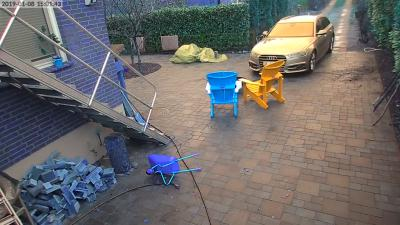

car: 38.61%
chair: 35.14%


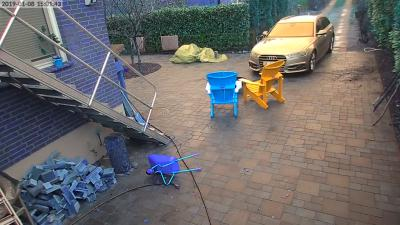

car: 38.61%
chair: 35.14%


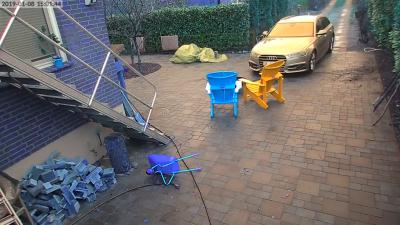

car: 38.61%
chair: 35.14%


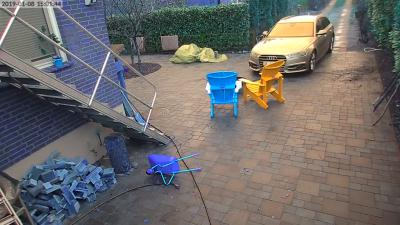

car: 38.61%
chair: 35.14%


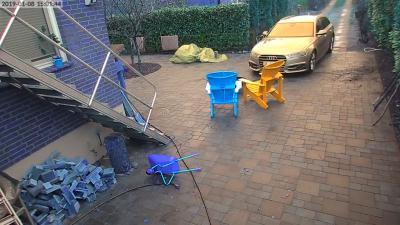

car: 38.61%
chair: 35.14%


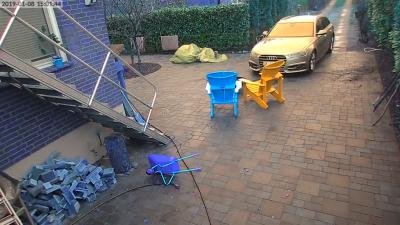

car: 38.61%
chair: 35.14%


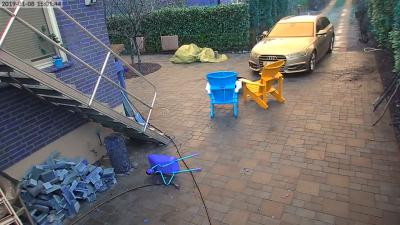

car: 38.61%
chair: 35.14%


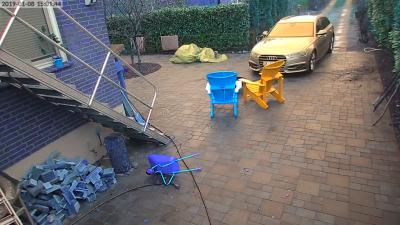

car: 38.61%
chair: 35.14%


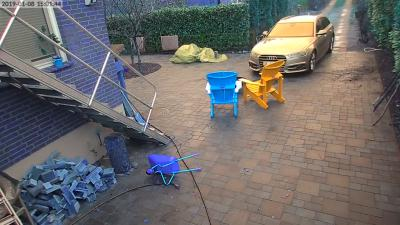

car: 38.61%
chair: 35.14%


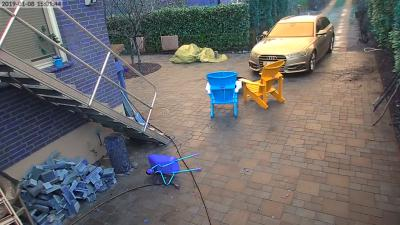

car: 38.61%
chair: 35.14%


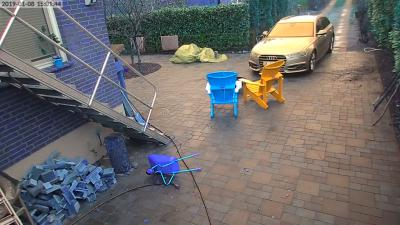

car: 38.61%
chair: 35.14%


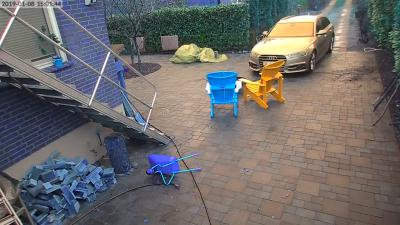

car: 38.61%
chair: 35.14%


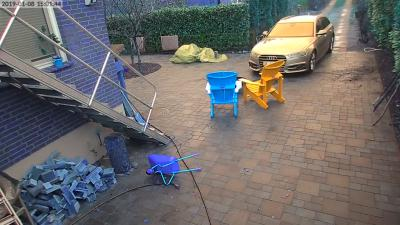

car: 38.61%
chair: 35.14%


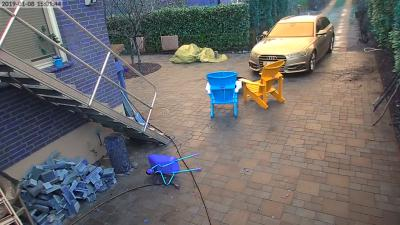

car: 38.61%
chair: 35.14%


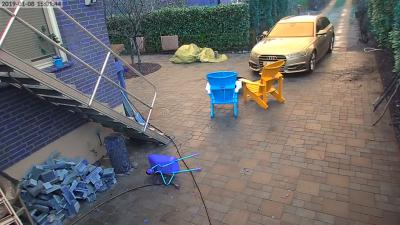

car: 38.61%
chair: 35.14%


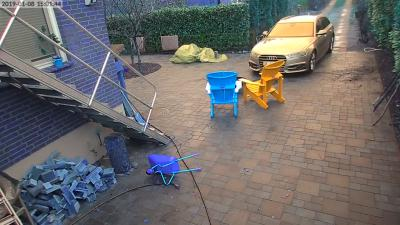

car: 38.61%
chair: 35.14%


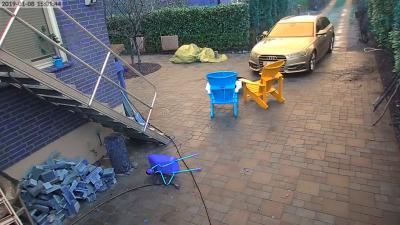

car: 38.61%
chair: 35.14%


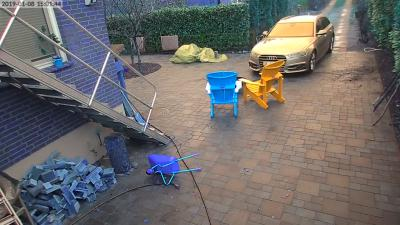

car: 38.61%
chair: 35.14%


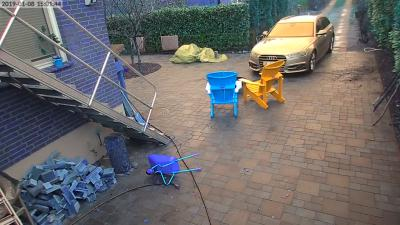

car: 38.61%
chair: 35.14%


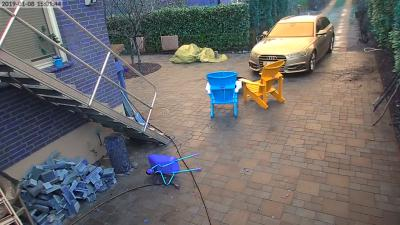

car: 38.61%
chair: 35.14%


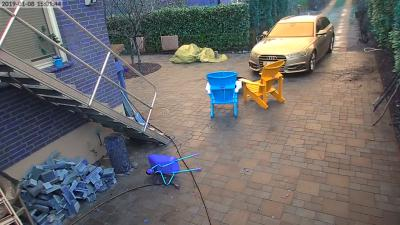

car: 38.61%
chair: 35.14%


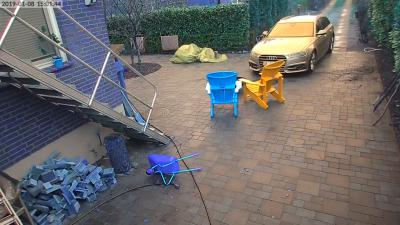

car: 38.61%
chair: 35.14%


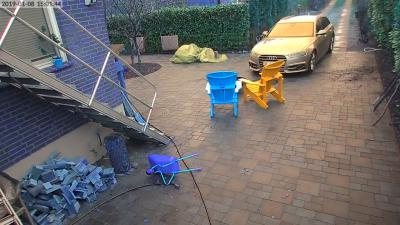

car: 38.61%
chair: 35.14%


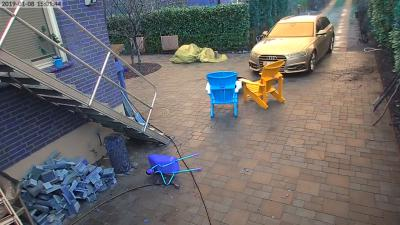

car: 38.61%
chair: 35.14%


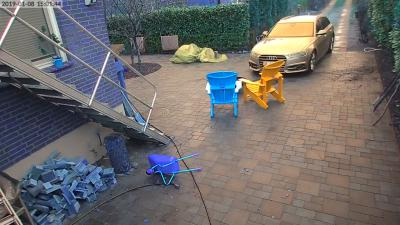

car: 38.61%
chair: 35.14%


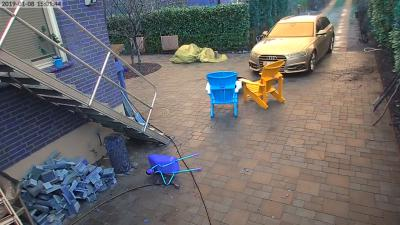

car: 38.61%
chair: 35.14%


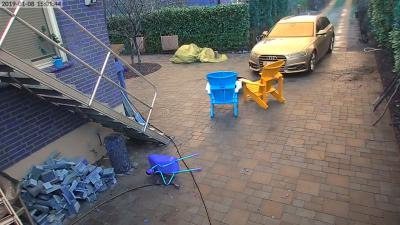

car: 38.61%
chair: 35.14%


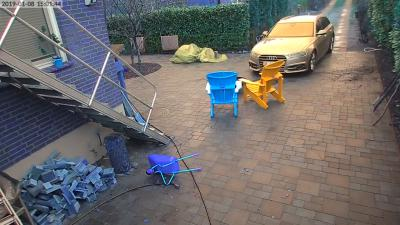

car: 38.61%
chair: 35.14%


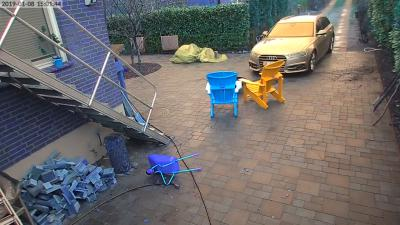

car: 38.61%
chair: 35.14%


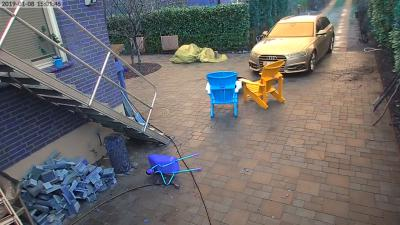

car: 38.61%
chair: 35.14%


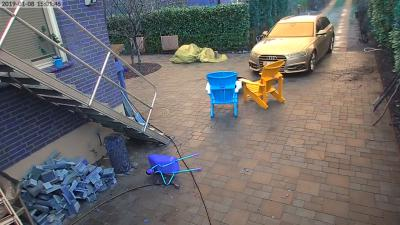

car: 38.61%
chair: 35.14%


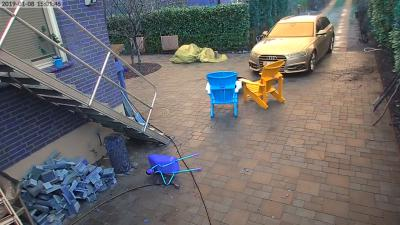

car: 38.61%
chair: 35.14%


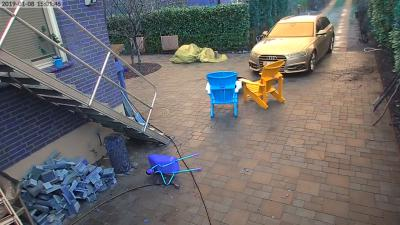

car: 38.61%
chair: 35.14%


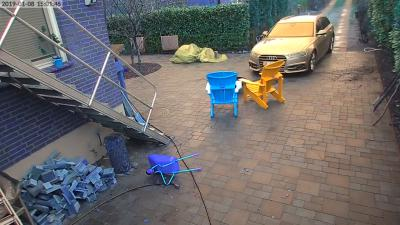

car: 38.61%
chair: 35.14%


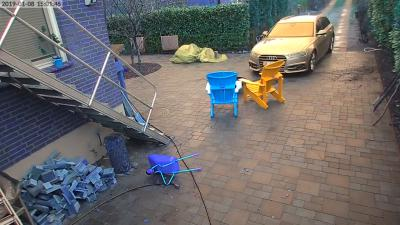

car: 38.61%
chair: 35.14%


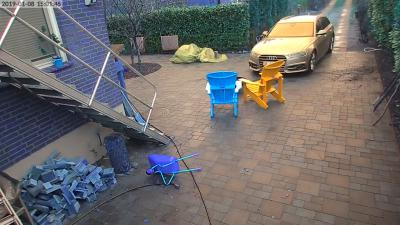

car: 38.61%
chair: 35.14%


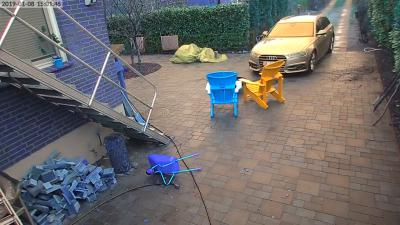

car: 38.61%
chair: 35.14%


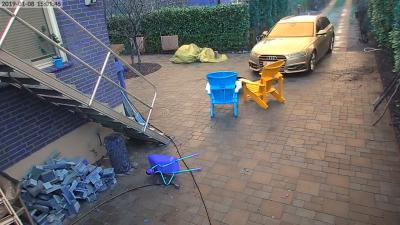

car: 38.61%
chair: 35.14%


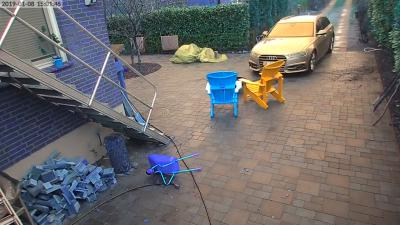

car: 38.61%
chair: 35.14%


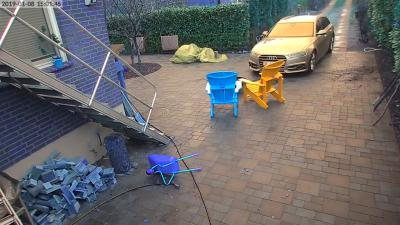

car: 38.61%
chair: 35.14%


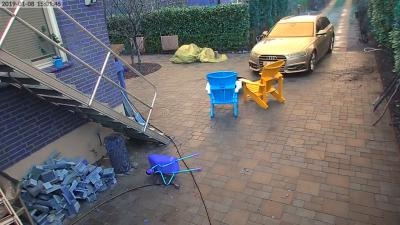

car: 38.61%
chair: 35.14%


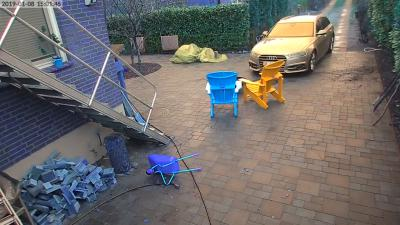

car: 38.61%
chair: 35.14%


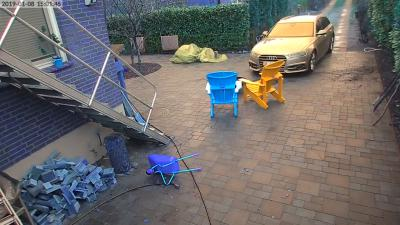

car: 38.61%
chair: 35.14%


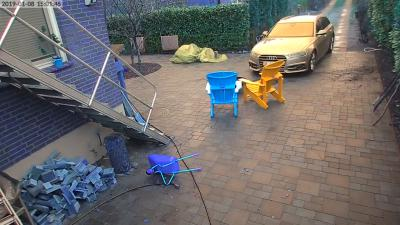

car: 38.61%
chair: 35.14%


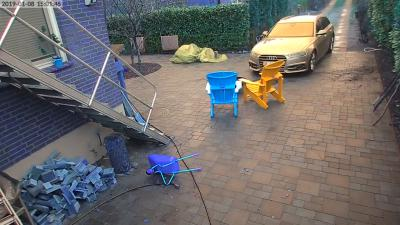

car: 38.61%
chair: 35.14%


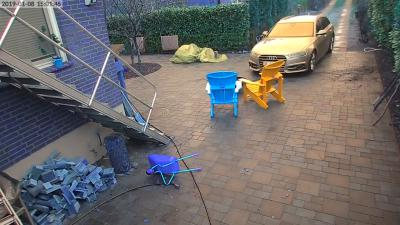

car: 38.61%
chair: 35.14%


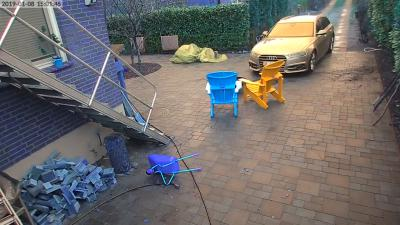

car: 38.61%
chair: 35.14%


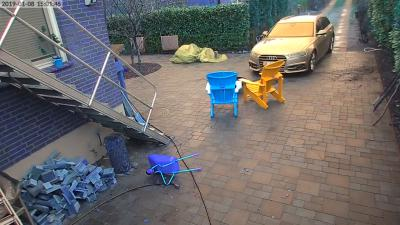

car: 38.61%
chair: 35.14%


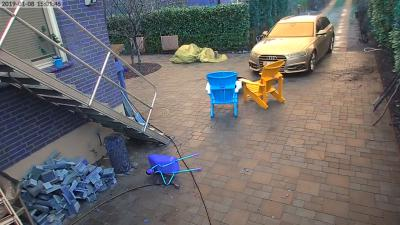

car: 38.61%
chair: 35.14%


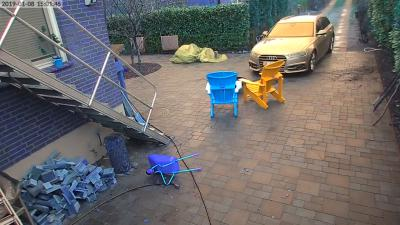

car: 38.61%
chair: 35.14%


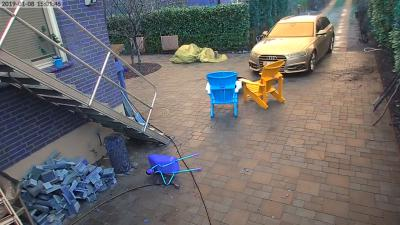

car: 38.61%
chair: 35.14%


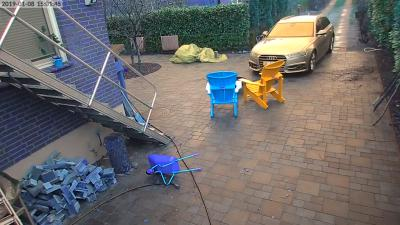

car: 38.61%
chair: 35.14%


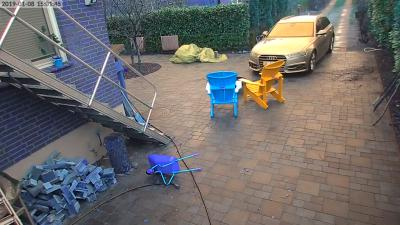

car: 38.61%
chair: 35.14%


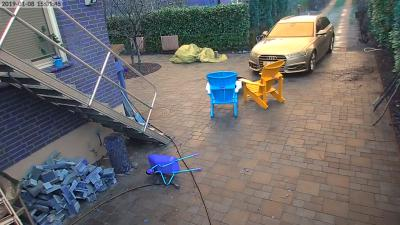

car: 38.61%
chair: 35.14%


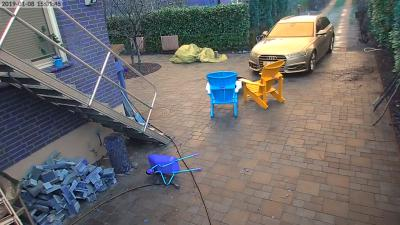

car: 38.61%
chair: 35.14%


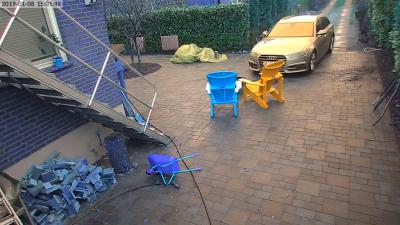

car: 38.61%
chair: 35.14%


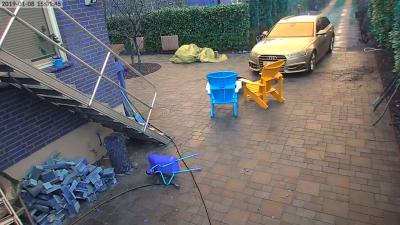

car: 38.61%
chair: 35.14%


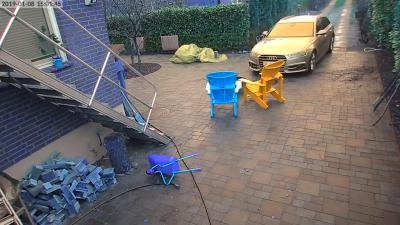

car: 38.61%
chair: 35.14%


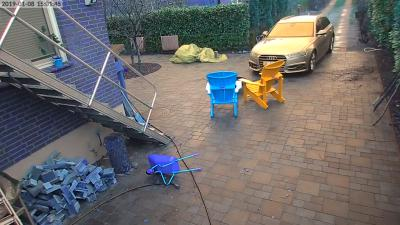

car: 38.61%
chair: 35.14%


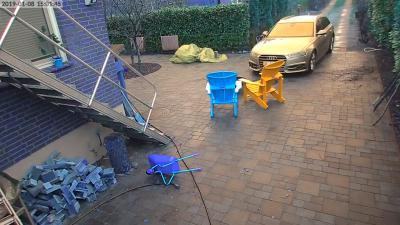

car: 38.61%
chair: 35.14%


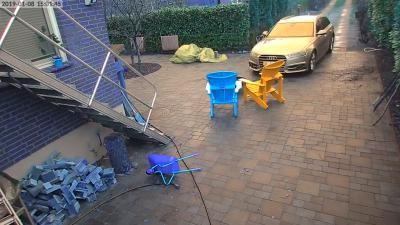

car: 38.61%
chair: 35.14%


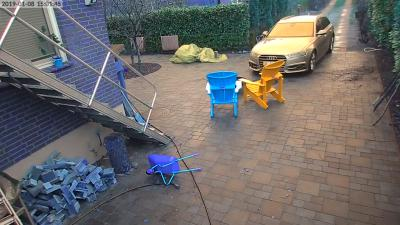

car: 38.61%
chair: 35.14%


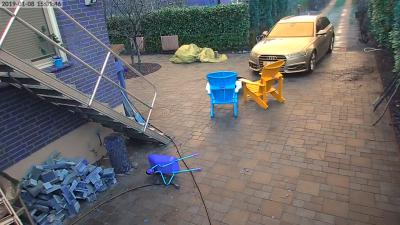

car: 38.61%
chair: 35.14%


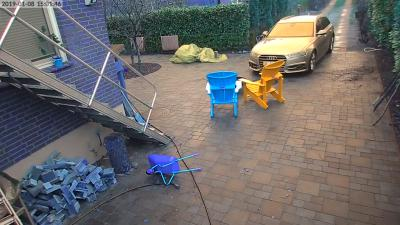

car: 38.61%
chair: 35.14%


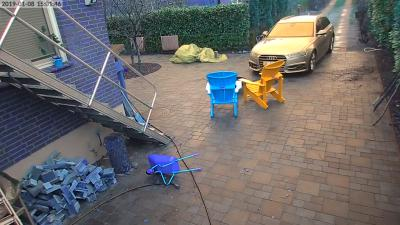

car: 38.61%
chair: 35.14%


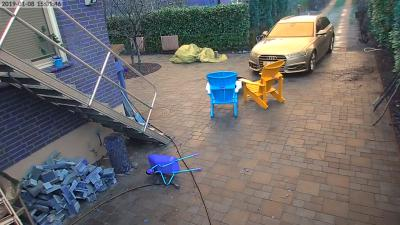

car: 38.61%
chair: 35.14%


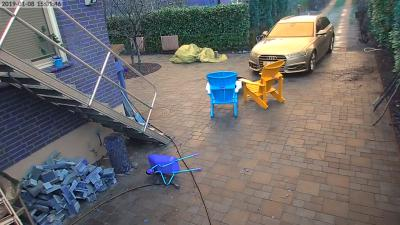

car: 38.61%
chair: 35.14%


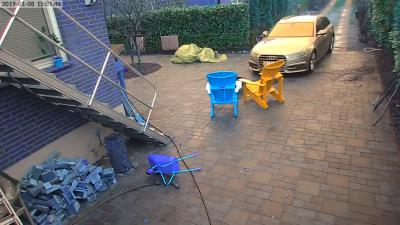

car: 38.61%
chair: 35.14%


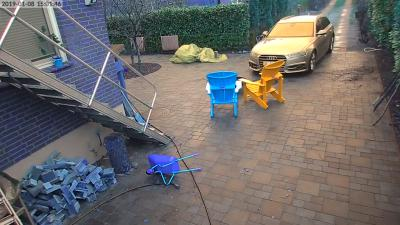

car: 38.61%
chair: 35.14%


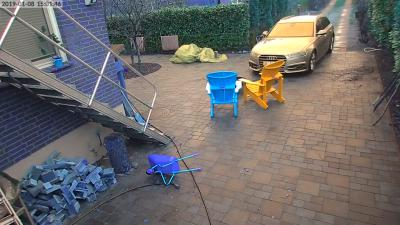

car: 38.61%
chair: 35.14%


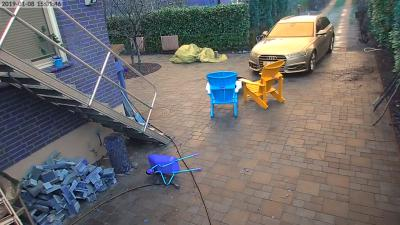

car: 38.61%
chair: 35.14%


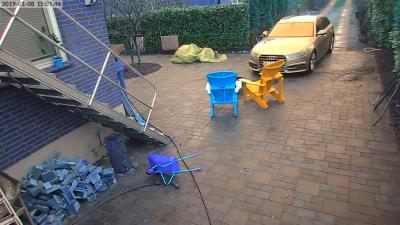

car: 38.61%
chair: 35.14%


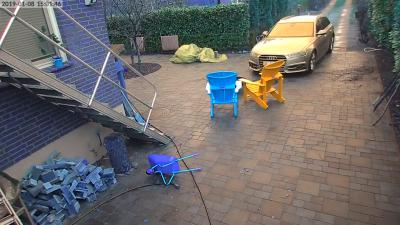

car: 38.61%
chair: 35.14%


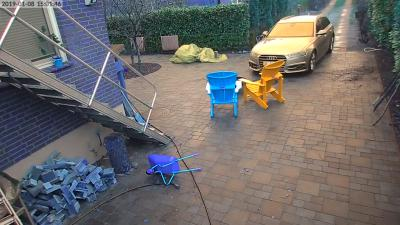

car: 38.61%
chair: 35.14%


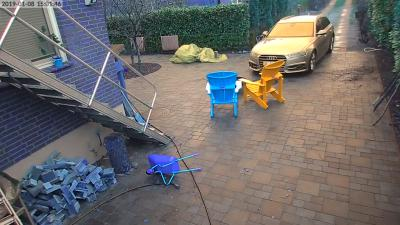

car: 38.61%
chair: 35.14%


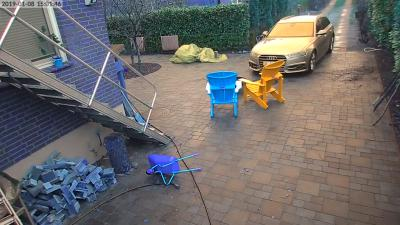

car: 38.61%
chair: 35.14%


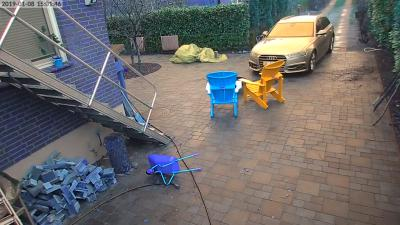

car: 38.61%
chair: 35.14%


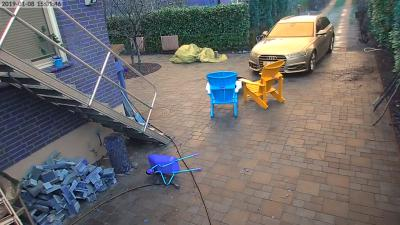

car: 38.61%
chair: 35.14%


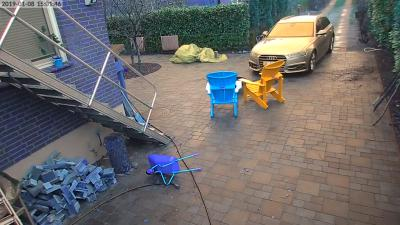

car: 38.61%
chair: 35.14%


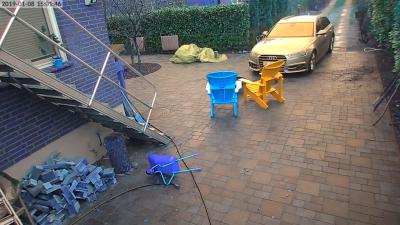

car: 38.61%
chair: 35.14%


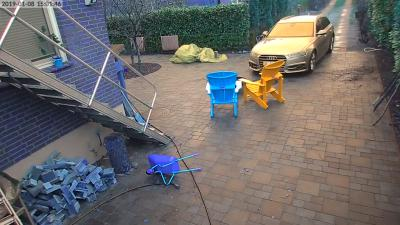

car: 38.61%
chair: 35.14%


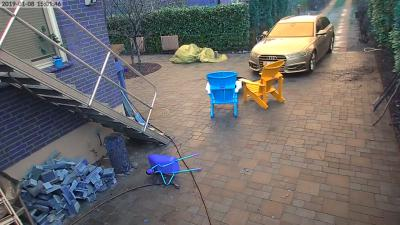

car: 38.61%
chair: 35.14%


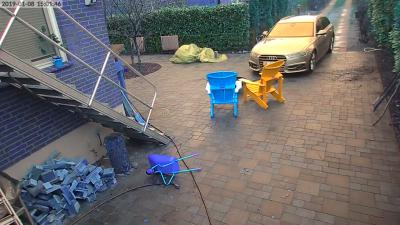

car: 38.61%
chair: 35.14%


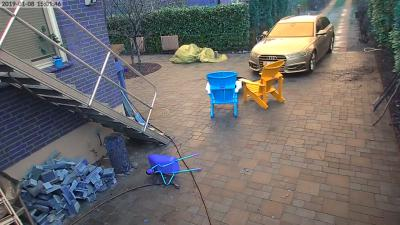

car: 38.61%
chair: 35.14%


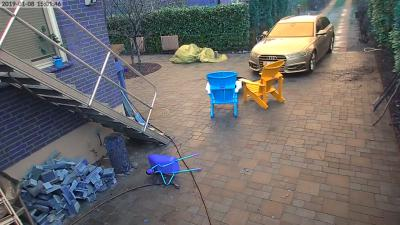

car: 38.61%
chair: 35.14%


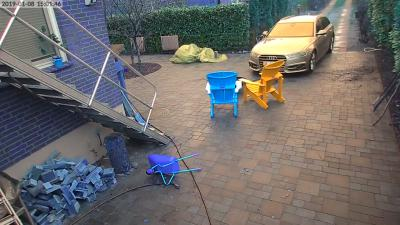

car: 38.61%
chair: 35.14%


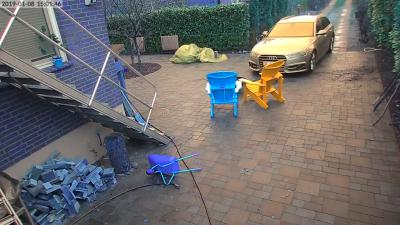

car: 38.61%
chair: 35.14%


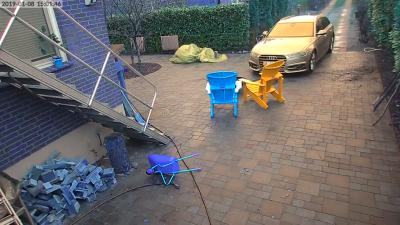

car: 38.61%
chair: 35.14%


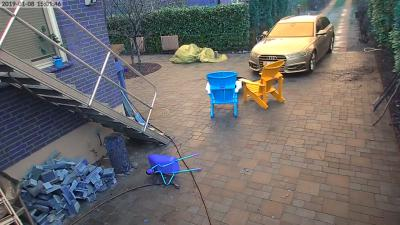

car: 38.61%
chair: 35.14%


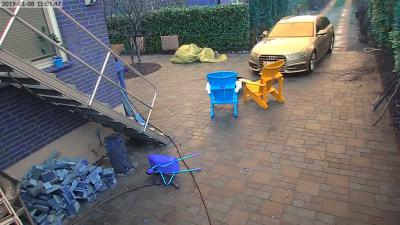

car: 38.61%
chair: 35.14%


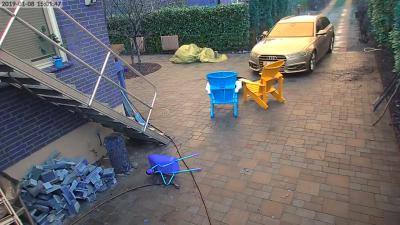

car: 38.61%
chair: 35.14%


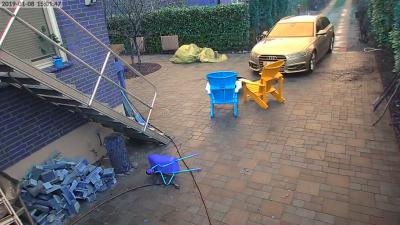

car: 38.61%
chair: 35.14%


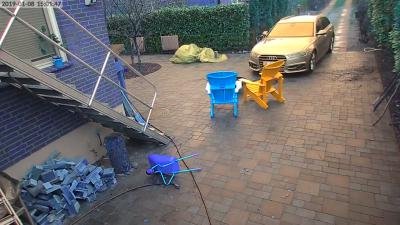

car: 38.61%
chair: 35.14%


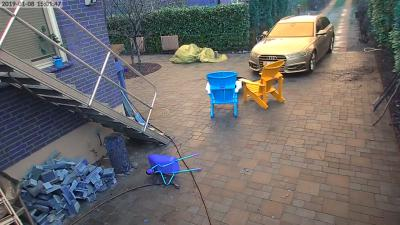

car: 38.61%
chair: 35.14%


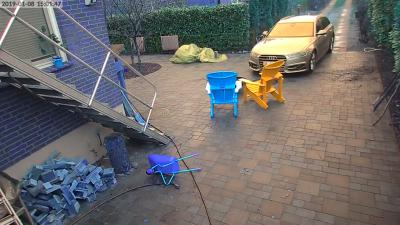

car: 38.61%
chair: 35.14%


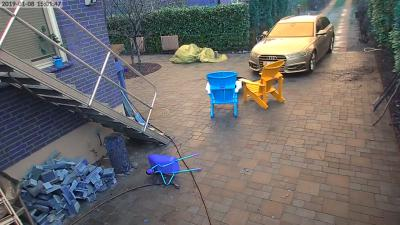

car: 38.61%
chair: 35.14%


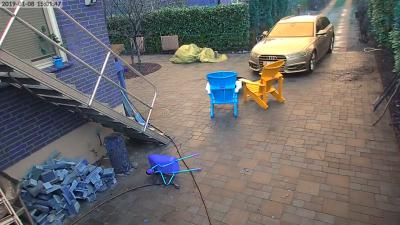

car: 38.61%
chair: 35.14%


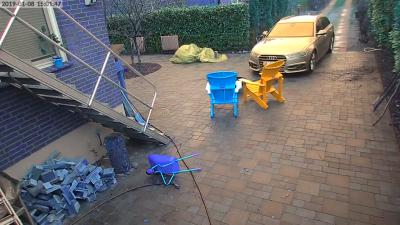

car: 38.61%
chair: 35.14%


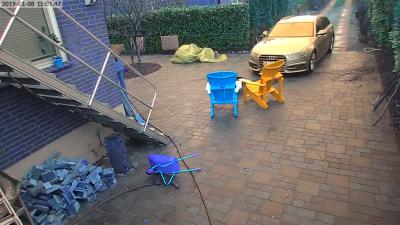

car: 38.61%
chair: 35.14%


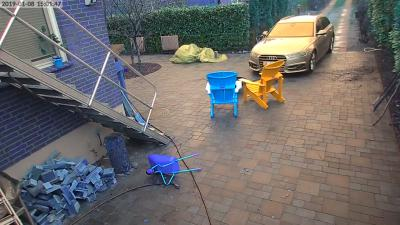

car: 38.61%
chair: 35.14%


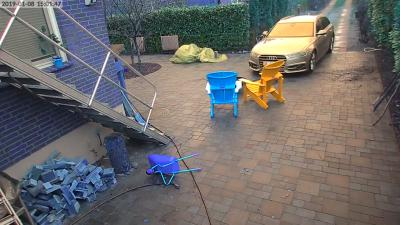

car: 38.61%
chair: 35.14%


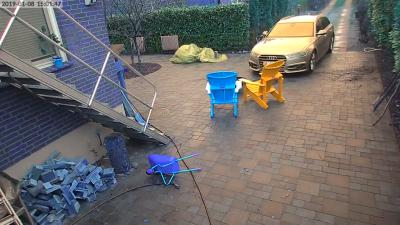

car: 38.61%
chair: 35.14%


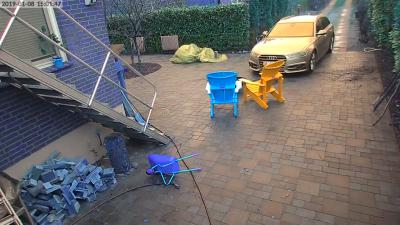

car: 38.61%
chair: 35.14%


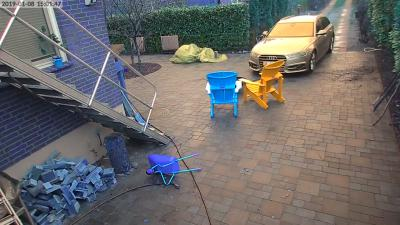

car: 38.61%
chair: 35.14%


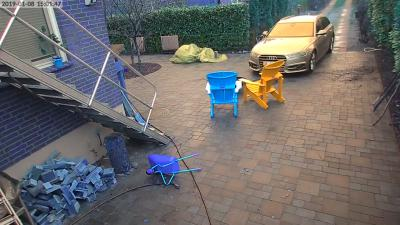

car: 38.61%
chair: 35.14%


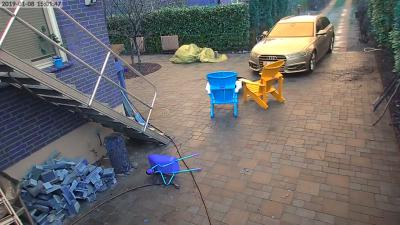

car: 38.61%
chair: 35.14%


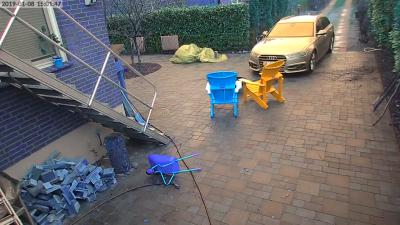

car: 38.61%
chair: 35.14%


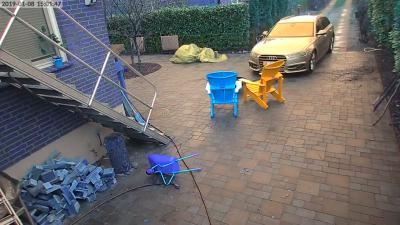

car: 38.61%
chair: 35.14%


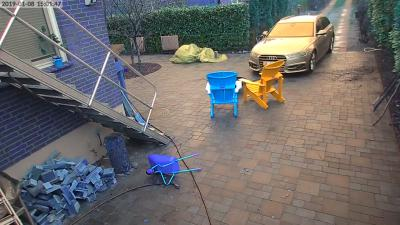

car: 38.61%
chair: 35.14%


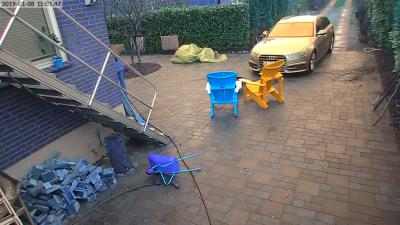

car: 38.61%
chair: 35.14%


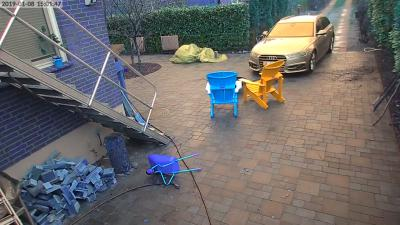

car: 38.61%
chair: 35.14%


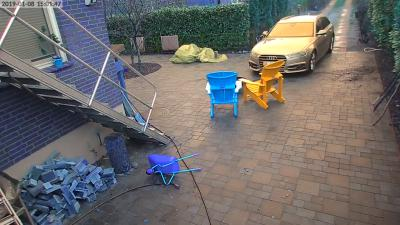

car: 38.61%
chair: 35.14%


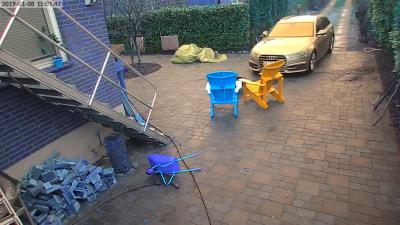

car: 38.61%
chair: 35.14%


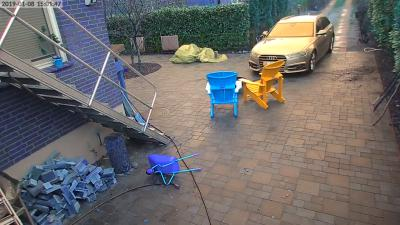

car: 38.61%
chair: 35.14%


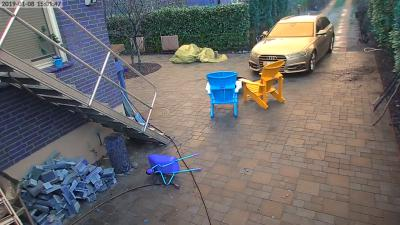

car: 38.61%
chair: 35.14%


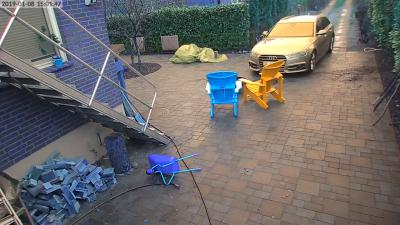

car: 38.61%
chair: 35.14%


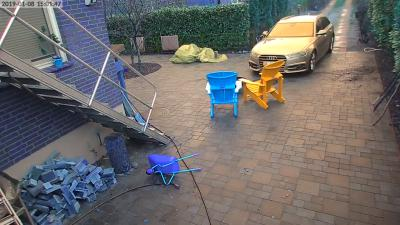

car: 38.61%
chair: 35.14%


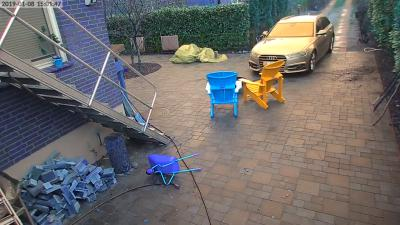

car: 38.61%
chair: 35.14%


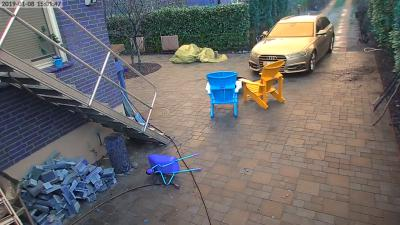

car: 38.61%
chair: 35.14%


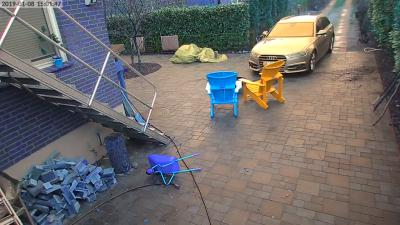

car: 38.61%
chair: 35.14%


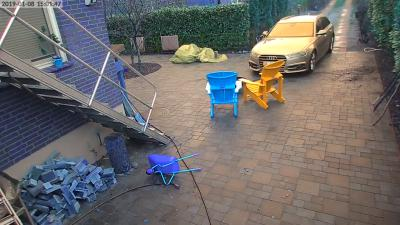

car: 38.61%
chair: 35.14%


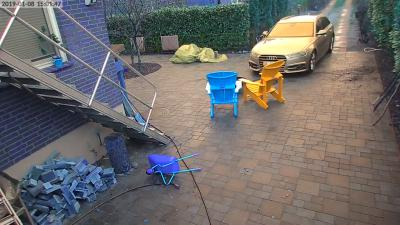

car: 38.61%
chair: 35.14%


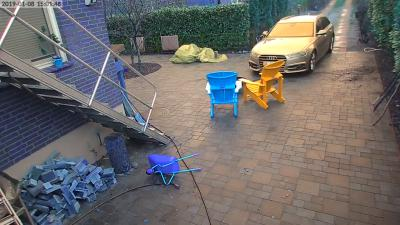

car: 38.61%
chair: 35.14%


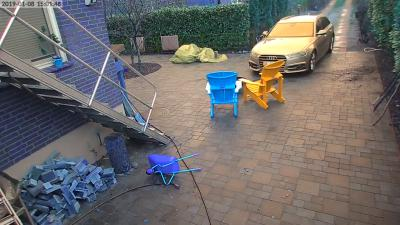

car: 38.61%
chair: 35.14%


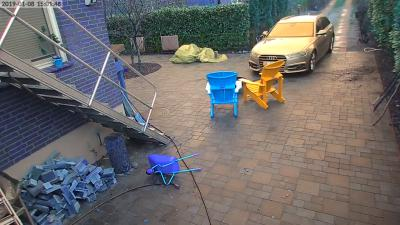

car: 38.61%
chair: 35.14%


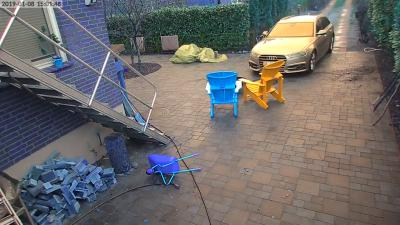

car: 38.61%
chair: 35.14%


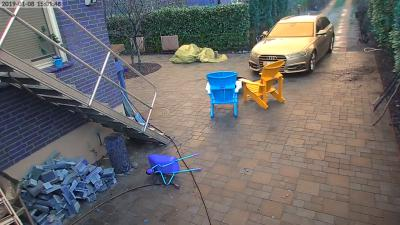

car: 38.61%
chair: 35.14%


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/PIL/ImageFile.py", line 487, in _save
    fh = fp.fileno()
io.UnsupportedOperation: fileno

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-d0ae074d7770>", line 4, in <module>
    showarray(img)
  File "<ipython-input-36-dc79c203d885>", line 36, in showarray
    PIL.Image.fromarray(a).save(f, fmt)
  File "/usr/local/lib/python3.7/site-packages/PIL/Image.py", line 1994, in save
    save_handler(self, fp, filename)
  File "/usr/local/lib/python3.7/site-packages/PIL/JpegImagePlugin.py", line 761, in _save
    ImageFile._save(im, fp, [("jpeg", (0, 0)+im.size, 0, rawmode)], bufsize)
  File "/usr/local/lib/python3.7/site-packages/PIL/ImageFile.py", line 501, in _save
    l, 

TypeError: can only concatenate str (not "list") to str

In [ ]:
while True:
    ret, img = vs.read()
    img = imutils.resize(img, width=400)
    showarray(img)
    if inputQueue.empty():
        #print('Queue empty.')
        inputQueue.put(frame)

# if the output queue *is not* empty, grab the detections
    if not outputQueue.empty():
        #print('Queue not empty. Grabbing detections.')
        detections = outputQueue.get()

    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated
        # with the prediction
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the `confidence`
        # is greater than the minimum confidence

        # extract the index of the class label from the `detections`
        idx = int(detections[0, 0, i, 1])
        label = "{}: {:.2f}%".format(CLASSES[idx],
            confidence * 100)
        print(label)

In [ ]:
ret, img = vs.read()
img = imutils.resize(img, width=400),
#showarray(img)

if inputQueue.empty():
    #print('Queue empty.')
    inputQueue.put(frame)

# if the output queue *is not* empty, grab the detections
if not outputQueue.empty():
    #print('Queue not empty. Grabbing detections.')
    detections = outputQueue.get()

for i in np.arange(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated
    # with the prediction
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the `confidence`
    # is greater than the minimum confidence

    # extract the index of the class label from the `detections`
    idx = int(detections[0, 0, i, 1])
    label = "{}: {:.2f}%".format(CLASSES[idx],
        confidence * 100)
    print(label)

In [ ]:
img